In [3]:
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import scipy.optimize
import seaborn as sns
import os
import tempfile

red, blue, green = sns.color_palette('Set1', 3)


from pyabc import ABCSMC, RV, Distribution
from pyabc.distance import AdaptivePNormDistance
import pyabc.distance
from pyabc.populationstrategy import AdaptivePopulationSize
import pyabc.visualization


from pyabc.sampler import SingleCoreSampler, MulticoreParticleParallelSampler
from pyabc.sge import nr_cores_available

from cnv_simulation import CNVsimulator_simpleWF, CNVsimulator_simpleChemo

First, define the simulator.  
N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV


"Observed data"  
Using simulations with known parameters for observed data.  

In [4]:
# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.001
m_snv=1e-5
generation = np.array(range(0,268))
# true parameters
true_params = np.log10(np.array([.1, 1e-5]))
labels_params = ['CNV fitness effect', 'CNV mutation rate']

Get one observation

In [5]:
obs_file = np.genfromtxt('WF_simulated_data.csv',delimiter=',')
observation = obs_file[0,0:25]
true_params = obs_file[0,25:27]
labels_params = ['CNV fitness effect', 'CNV mutation rate']
model="WF"
exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
dict_observed_WF = {}
i = 0
for keys in exp_gen:
    dict_observed_WF[keys] = np.array(observation[i])
    i+=1

Text(130, 0.5, 'Simulated observation\nmodel: WF\nlog10(CNV fitness): -1.0\nlog10(CNV mutation rate): -5.0\nSNV fitness:0.001\nSNV mutation rate:1e-05')

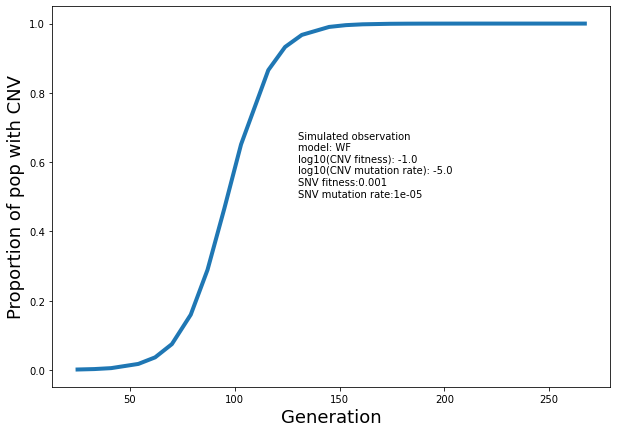

In [6]:
gens=np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])

title='Simulated observation\nmodel: WF' +'\nlog10(CNV fitness): ' + str(true_params[0]) + '\nlog10(CNV mutation rate): ' + str(true_params[1]) + '\nSNV fitness:' + str(s_snv) + '\nSNV mutation rate:' + str(m_snv)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(gens,observation.reshape(-1),linewidth=4)
#fig.tight_layout()
plt.xlabel("Generation", size=18)
plt.ylabel("Proportion of pop with CNV", size=18)
ax.text(x=130,y=0.5, s=title)

Wrapper, pyABC requires simulation to return a dictionary

In [7]:
reps=1
def simulate_pyabc(parameters):
    if model == "WF":
        res = CNVsimulator_simpleWF(reps=reps, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=parameters)
    if model == "Chemo":
        res = CNVsimulator_simpleChemo(reps=reps, A_inoculation=A_inoculation, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, parameters=parameters)
    exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
    pyabc_dict = {}
    i = 0
    for keys in exp_gen: 
        pyabc_dict[keys] = np.array(res[:,i].item())
        i+=1
    return pyabc_dict


Prior over model parameters. Model parameters are CNV fitness effects and CNV mutation rates. Will use a uniform distribution over the log of the priors.

In [8]:
prior = Distribution(
    s=RV("uniform", np.log10(1e-4), np.log10(0.3)-np.log10(1e-4)),
    m=RV("uniform", np.log10(1e-12), np.log10(1e-3)-np.log10(1e-12))
)

Create the ABCSMC object, given the model, the prior, and the distance function $\rho$, which we set to AdaptivePNormDistance which is the adaptive Euclidean distance.

In [9]:
particle_size=1000
abc = ABCSMC(models=simulate_pyabc,
             parameter_priors=prior,
             distance_function=AdaptivePNormDistance(p=2, 
                                                     scale_function=pyabc.distance.root_mean_square_deviation),
             sampler=SingleCoreSampler(), #local
             #sampler=MulticoreParticleParallelSampler(), #hpc
             population_size=AdaptivePopulationSize(start_nr_particles=particle_size))
print("Cores: " + str(nr_cores_available()))

Cores: 1


In [10]:
# and we define where to store the results
db_path_WF = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "WF.db"))
history_WF = abc.new(db_path_WF, dict_observed_WF)

INFO:History:Start <ABCSMC(id=1, start_time=2021-04-09 15:20:13.691778, end_time=None)>


In [11]:
print("ABC-SMC run ID:", history_WF.id)

ABC-SMC run ID: 1


In [12]:
# We run the ABC until either criterion is met
history_WF = abc.run(minimum_epsilon=0.5, max_nr_populations=3) 
#for hpc, decrease epsilon, increase max pops

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.8509148592391595
INFO:ABC:t: 0, eps: 0.8509148592391595.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:ABC:Acceptance rate: 1000 / 1959 = 5.1046e-01, ESS=1.0000e+03.
INFO:Adaptation:Change nr particles 1000 -> 6853
INFO:ABC:t: 1, eps: 0.9112991823352029.
INFO:ABC:Acceptance rate: 6853 / 15533 = 4.4119e-01, ESS=6.3550e+03.
INFO:Adaptation:Change nr particles 6853 -> 3963
INFO:ABC:t: 2, eps: 0.3461893706505704.
INFO:ABC:Acceptance rate: 3963 / 8516 = 4.6536e-01, ESS=3.5945e+03.
INFO:Adaptation:Change nr particles 3963 -> 6812
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2021-04-09 15:20:13.691778, end_time=2021-04-09 15:31:03.127815)>


In [13]:
# to numpy array
params, weights = history_WF.get_distribution()
fitness_samples = np.asarray(params['s'])
mut_samples = np.asarray(params['m'])

In [14]:
fitness_samples.shape

(3963,)

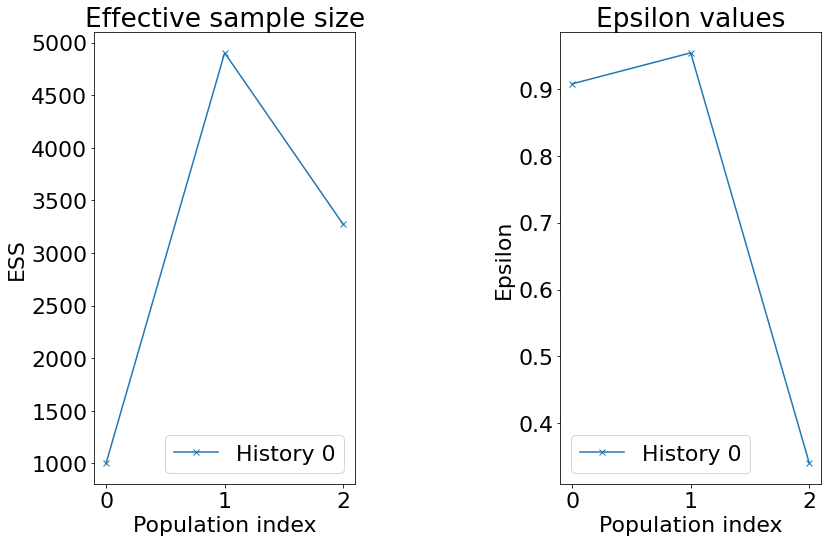

In [94]:
fig, axes = plt.subplots(1, 2)
pyabc.visualization.plot_effective_sample_sizes(history_WF, ax=axes[0])
pyabc.visualization.plot_epsilons(history_WF, ax=axes[1])
plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

After ABC:
* obtain MAP
    * get euclidean dist between MAP and simulation parameter
* plot marginal histograms
    * get marginal 95% HDIs
* plot joint density
    * 50%, 95%, 99% HDRs
* perform posterior predictive check:
    * generate predictions with MAP
    * compute distance between prediction and observation
    * Calculate AIC
    * get median distance of predictions from observation -> this should actually be median distance using many MAPs from independent rounds
* Draw 50 samples from posterior 
    * generate predictions
    * compute distance between prediction and observation
    * Calculate DIC
    

Distance function for distance between posterior parameters and observation parameters:

 
$$
d(x,y) = \sqrt{((\mu_x- \mu_y)^2 + (s_x - s_y)^2 }
$$

where  
$\mu$ = mutation rate   
$s$ = fitness effect



In [96]:
# distance between a simulation and "observation" 
def param_distance(simulation, observation):
    # simulation and observation are both arrays of parameters of size 2
    simulation = np.power(10,simulation)
    observation = np.power(10, observation)
    d = ((simulation[0]-observation[0])**2 + (simulation[1]-observation[1])**2)**0.5
    return d

In [138]:
#calculations kde
ymin = params['s'].min()
ymax = params['s'].max()
xmin = params['m'].min()
xmax = params['m'].max()

s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
s_range = np.vstack((s_range, np.repeat(true_params[0], 100)))
μ_range = np.vstack((μ_range, np.repeat(true_params[1], 100)))
s_range = s_range[np.argsort(s_range[:, 0])]
μ_range = μ_range[np.argsort(μ_range[:, 0])]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([params['s'], params['m']])
kernel = scipy.stats.gaussian_kde(values, weights=weights)
density = np.reshape(kernel(positions).T, s_range.shape)

#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
def kernelminus(x):
    return -kernel(x)
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', 
 options={'disp': True}).x
map_dist = param_distance(np.array([s_est, μ_est]),true_params)
map_log_like = kernel([s_est, μ_est])

Optimization terminated successfully.
         Current function value: -0.281295
         Iterations: 28
         Function evaluations: 54


/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


Text(0.5, 1.0, 'Wright-Fisher ABC joint posterior distribution')

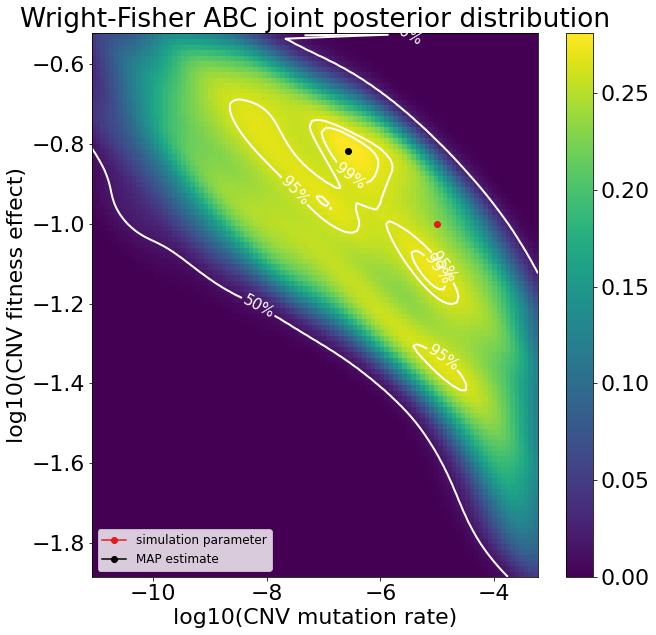

In [98]:
#get values from contour

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pyabc.visualization.plot_kde_2d_highlevel(history_WF, 'm', 's', numx=100, numy=100, ax=ax)
CS = ax.contour(μ_range, s_range, density, levels = np.quantile(density, q=[0.5,0.95,0.99]),
                colors=('w',),linestyles=('-',),linewidths=(2,))
fmt = {}
strs = [ '50%', '95%', '99%']
for l,s in zip( CS.levels, strs ):
    fmt[l] = s
ax.clabel(CS, CS.levels, fmt=fmt, inline=1, fontsize=15)
ax.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter")
ax.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate")
ax.legend(loc='lower left', prop={'size': 12})
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("Wright-Fisher ABC joint posterior distribution")

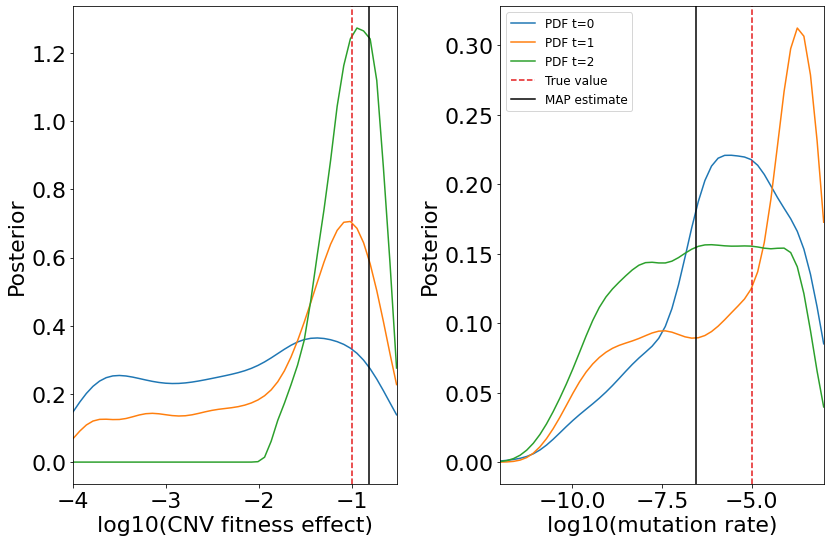

In [106]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2)
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0,t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=np.log10(1e-4), xmax=np.log10(0.3),
                                       x='s', ax=axes[0],
                                       label="PDF t={}".format(t))
        pyabc.visualization.plot_kde_1d(df, w, xmin=np.log10(1e-12), xmax=np.log10(1e-3),
                                       x='m', ax=axes[1],
                                       label="PDF t={}".format(t))
    axes[0].axvline(true_params[0], linestyle='dashed', label="True value", color=red)
    axes[1].axvline(true_params[1], linestyle='dashed', label="True value", color=red)
    axes[0].axvline(s_est, color="k", label="MAP estimate")
    axes[1].axvline(μ_est, color="k", label="MAP estimate")
    axes[0].set(xlabel='log10(CNV fitness effect)')
    axes[1].set(xlabel='log10(mutation rate)')
    plt.gcf().set_size_inches((12, 8))
    plt.gcf().tight_layout()
    plt.legend(prop={'size': 12})


plot_history(history_WF)

Distance between simulation and observation:

 
$$
d(x,y) = \sum_i (x_i - y_i)^2 
$$

where   
i = timepoint 


In [108]:
def distance(obs, exp):
    return np.sum((obs-exp)**2)

In [141]:
#draw from posterior
idx = np.random.choice(params.shape[0], 50, replace=False)
params_post = np.array([np.asarray(fitness_samples[idx]), np.asarray(mut_samples[idx])]).T

#simulate based on drawn params, calculate distance, calculate probability
dist_posterior = []
evo_reps_posterior = []
loglike_posterior = []
for i in range(50):
    if model == "WF":
        obs_post = CNVsimulator_simpleWF(reps=reps, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=params_post[i,:])
    if model == "Chemo":
        obs_post = CNVsimulator_simpleChemo(reps=reps, A_inoculation=A_inoculation, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, parameters=params_post[i,:])
    
    evo_reps_posterior.append(obs_post)
    dist_posterior.append(distance(obs_post,observation))
    loglike_posterior.append(kernel(params_post[i,:]))

In [143]:
evo_reps_posterior = np.vstack(evo_reps_posterior)
dist_posterior = np.vstack(dist_posterior)
loglike_posterior = np.vstack(loglike_posterior)

Text(0.5, 0.98, 'WF, ABC')

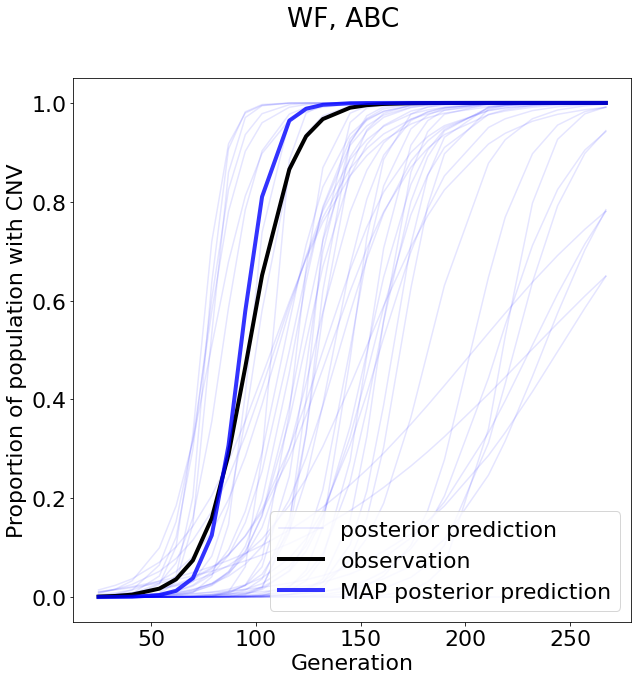

In [144]:
if model == "WF":
    post_prediction_map = CNVsimulator_simpleWF(reps=reps, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=np.array([s_est, μ_est]))
if model == "Chemo":
    post_prediction_map = CNVsimulator_simpleChemo(reps=reps, A_inoculation=A_inoculation, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, parameters=np.array([s_est, μ_est]))

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.set_ylim(0,1)
for i in range(49) :
    ax.plot(gens, evo_reps_posterior[i,:], color='blue',alpha=0.1)
ax.plot(gens, evo_reps_posterior[49,:], color='blue',alpha=0.1, label = 'posterior prediction')
ax.plot(gens,observation.reshape(-1),linewidth=4, label = 'observation', color = 'black')
ax.plot(gens,post_prediction_map.reshape(-1),linewidth=4, alpha=0.8, label = 'MAP posterior prediction', color='blue')
ax.legend(loc='lower right')
ax.set_xlabel('Generation')
ax.set_ylabel('Proportion of population with CNV')
plt.suptitle('WF, ABC')

In [150]:
aic = map_log_like + 2*2
dic = 2*(kernel([fitness_samples.mean(), mut_samples.mean()]) - (1/50)*loglike_posterior.sum())

#marginal 95 hdis
fit_95hdi_low,fit_95hdi_high = pyabc.visualization.credible.compute_credible_interval(vals=fitness_samples, weights=weights)
mut_95hdi_low,mut_95hdi_high = pyabc.visualization.credible.compute_credible_interval(vals=mut_samples, weights=weights)

(-1.6976979251056963, -0.5772634608022703)

In [97]:
f= open("est_real_params.csv","a+")
f.write(model+',ABC,'.join(str(format(j)) 
                                      for j in
                                      (particle_size, true_params[0],s_est,true_params[1],
                                       μ_est,s_snv,m_snv,map_dist,
                                       fit_95hdi_low,fit_95hdi_high,
                                       mut_95hdi_low,mut_95hdi_high,
                                       aic, dic)) + '\n')
f.close() 

NameError: name 'particle_size' is not defined

In [98]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

seaborn==0.11.1
scipy==1.6.0
pyabc==0.10.3
numpy==1.19.4
matplotlib==3.3.4


In [56]:
kernel = scipy.stats.gaussian_kde(params.values.reshape(2, weights.shape[0]).tolist(), weights=weights.tolist())